# Plot abrupt CO2 anomalies and fit linear response using all available members

In [9]:
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import os

from scipy import optimize
#import importlib
from estimation import *
from plotting_functions import *

In [28]:
exp = 'abrupt-0p5xCO2'
#exp = 'abrupt-2xCO2'
#exp = 'abrupt-4xCO2'

directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()
exp_models = []
#model_names[40:50]
for model in model_names:
    model_exp = [ f.name for f in os.scandir(directory + model) if f.is_dir() and f.name !='.ipynb_checkpoints']
    if exp in model_exp:
        exp_models.append(model)

In [29]:
exp_models

['CESM2',
 'CNRM-CM6-1',
 'CanESM5',
 'GISS-E2-1-G',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0',
 'TaiESM1']

In [30]:
save_parameters = True

for model in ['HadGEM3-GC31-LL']:
#for model in exp_models:
#for model in [exp_models[0]]:
#for model in model_names[41:]:
    if os.path.isdir(os.path.join(directory, model, exp)) == False:
        continue
    members = find_members(model, exp)
        
    if model == 'GISS-E2-1-G' and exp == 'abrupt-4xCO2':
        # exclude member which seems to start after year 150
        members.remove('r1i1p1f3')
    print(model, members)
    
    #f.plot_allvar(model, exp, members)
    parameters_names = ['tau1', 'tau2', 'tau3', 'tau4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x', 'T2x','rnorm']
    df_par = pd.DataFrame(columns=parameters_names)

    ii = 0
    while ii < 1000:
        par_list = fbpar_estimation(model, exp, members)
        
        if len(par_list) == 0:
            continue
        else:
            [timescales, a_n, b_n, rnorm1, rnorm2] = par_list
        
        if a_n[-1]<0: # response at multimillennial time scale should be positive
            continue
        if rnorm2 > rnorm1*1.1: 
            # response at multimillenial time scale should be close to 0 for the first 150 years
            # and should therefore not lead to a significantly worse fit if included
            continue
        #print(a_n)
        
        # saved values assume CO2 forcing is logarithmic with concentration,
        # but these values are not used further.
        # the saved values for a_n and b_n are here defined using the respective forcings,
        # rather than the 4xCO2 forcing
        if exp == 'abrupt-4xCO2':
            F2x = np.sum(b_n)/2
            T2x = np.sum(a_n)/2
        elif exp in ['abrupt-2xCO2', 'abrupt-0p5xCO2']:
            # save parameters with positive signs also for the negative response in 0p5xCO2
            # (since I want to plot it with a positive sign)
            F2x = np.sum(b_n)
            T2x = np.sum(a_n)
        # write results to table
        pars = np.concatenate((timescales, a_n, b_n, F2x, T2x, rnorm1), axis=None)
        #df_par = df_par.append(pd.DataFrame([pars], columns=parameters_names), ignore_index=True)
        df_par = pd.concat((df_par, pd.DataFrame([pars], columns=parameters_names)), ignore_index=True)
        if ii % 100 == 0:
            print(ii)
        ii += 1

    # save file
    modelfilename = model + '_1000parameters.csv' # shortest time scale 1-6 yrs
    if save_parameters == True:
        if exp == 'abrupt-4xCO2':
            df_par.to_csv('../Estimates/1000parameters_4xCO2_allmembers/' + modelfilename)
        elif exp == 'abrupt-2xCO2':
            df_par.to_csv('../Estimates/1000parameters_2xCO2_allmembers/' + modelfilename)
        elif exp == 'abrupt-0p5xCO2':
            df_par.to_csv('../Estimates/1000parameters_0p5xCO2_allmembers/' + modelfilename)

# If this loops goes on forever, it is probably because the time series have less than 150 years of data

HadGEM3-GC31-LL ['r1i1p1f3']
0
100
200
300
400
500
600
700
800
900


In [18]:
ii

1000

In [31]:
df_par

,tau1,tau2,tau3,tau4,a_1,a_2,a_3,a_4,b_1,b_2,b_3,b_4,F2x,T2x,rnorm
0,1.053389,5.738568,547.679075,5000.0,0.223904,2.119396,3.161867,1.775363,0.812996,3.072379,0.706790,0.396857,4.989022,7.280531,2.127569
1,1.152973,5.804630,80.530544,5000.0,0.402899,1.777511,1.003804,2.401639,0.883543,2.663392,0.366329,0.876456,4.789719,5.585854,2.129881
2,1.154234,7.423751,157.758643,5000.0,0.571593,1.760944,1.173390,3.619988,-0.320816,2.520171,0.271961,0.839018,3.310333,7.125915,2.078288
3,1.054872,6.489182,112.121445,5000.0,0.459861,1.803842,1.058128,3.804085,-2.515692,2.717715,0.245246,0.881687,1.328956,7.125915,2.103272
4,5.933542,41.665563,96.144039,5000.0,2.268742,0.000000,0.959256,3.897917,3.430155,-0.000000,0.222330,0.903434,4.555919,7.125915,2.170603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.028746,5.644328,151.255558,5000.0,0.276214,1.993670,1.268698,3.587333,1.014142,3.022202,0.294051,0.831449,5.161845,7.125915,2.127091
996,1.262158,7.797217,111.849306,5000.0,0.659642,1.645056,0.987185,3.834031,-0.161564,2.399220,0.228803,0.888627,3.355087,7.125915,2.085954
997,4.784613,26.090044,90.238377,5000.0,2.085313,0.217369,0.890521,3.932711,3.871660,-0.086102,0.206399,0.911499,4.903456,7.125915,2.161307
998,1.448902,11.155108,85.654991,5000.0,0.999397,1.359148,0.776295,4.145691,0.240515,2.051063,0.173530,0.926710,3.391817,7.280531,2.109435


# Plot results and save the best fit parameters

HadGEM3-GC31-LL


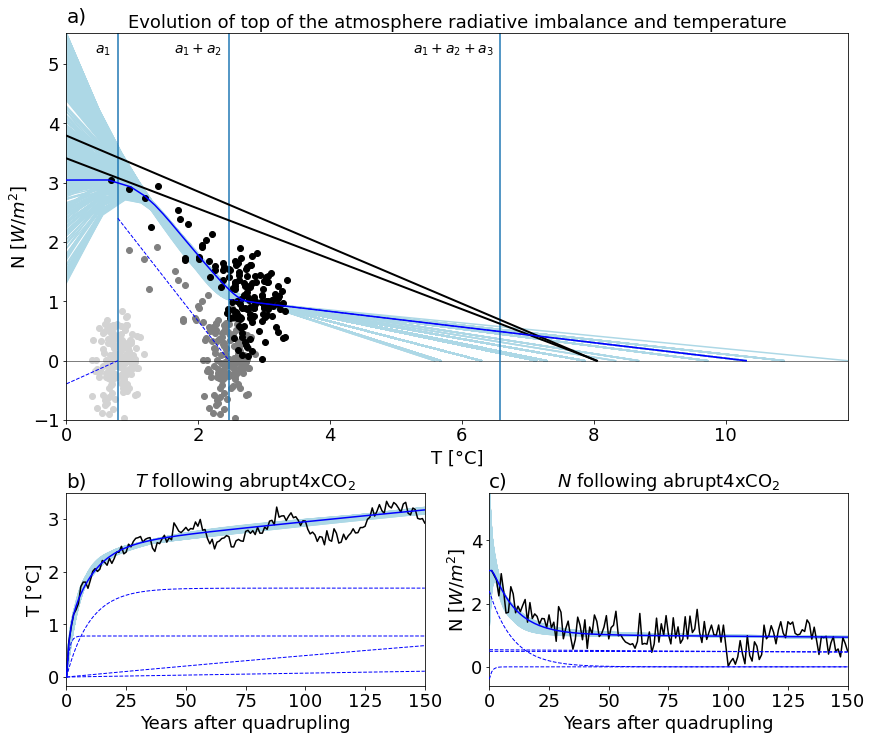

In [32]:
#create_newfile = True
create_newfile = False
save_filename = 'best_estimated_parameters_allmembers0p5xCO2.csv'
#save_filename = 'best_estimated_parameters_allmembers2xCO2.csv'
#save_filename = 'best_estimated_parameters2_allmembers4xCO2.csv'
savefig = False
letters = ['a)', 'b)', 'c)']

for model in ['HadGEM3-GC31-LL']:
#for model in [exp_models[0]]:
#for model in exp_models:
#for model in model_names:
    print(model)
    filename = model + '_1000parameters.csv';
    fileinclpath = '../Estimates/1000parameters_0p5xCO2_allmembers/' + filename
    #fileinclpath = '../Estimates/1000parameters_2xCO2_allmembers/' + filename
    #fileinclpath = '../Estimates/1000parameters_4xCO2_allmembers/' + filename
    if os.path.isfile(fileinclpath) == False:
        #print(model)
        continue
    df_par = pd.read_csv(fileinclpath,index_col=0)
    members = find_members(model, exp)
    if model == 'GISS-E2-1-G' and exp == 'abrupt-4xCO2':
        # exclude member which seems to start after year 150
        members.remove('r1i1p1f3')
    
    # find maximum values that needs to be plotted
    T2x_max = np.max(df_par.loc[:,'T2x'])
    F2x_max = np.max(df_par.loc[:,'F2x'])
    best_rnorm = np.min(df_par['rnorm']);

    fig = plt.figure(figsize = [14,12]);
    #make outer gridspec
    outer = gridspec.GridSpec(2, 1, height_ratios = [2, 1],  hspace = 0.25) 
    #make nested gridspecs
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0], hspace = 0.1)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec = outer[1], wspace = 0.18)

    if exp == 'abrupt-4xCO2':
        Gax = fig.add_subplot(gs1[0]); Gax = Gregory_subplot(Gax, x_max = 2*T2x_max, y_max = 2*F2x_max)
        Nax = fig.add_subplot(gs2[1]); Nax = toaradresponse_subplot(Nax, y_max = 2*F2x_max)
    else:
        Gax = fig.add_subplot(gs1[0]); Gax = Gregory_subplot(Gax, x_max = T2x_max, y_max = F2x_max)
        Nax = fig.add_subplot(gs2[1]); Nax = toaradresponse_subplot(Nax, y_max = F2x_max)
    Tax = fig.add_subplot(gs2[0]); Tax = tasresponse_subplot(Tax)
    
    Tax = plot_Tvstime(Tax, model, exp, members, include_mean = False)
    Nax = plot_Nvstime(Nax, model, exp, members, include_mean = False)
    Gax = plot_NvsT(Gax, model, exp, members)

    if exp == 'abrupt-4xCO2':
        # include fixed-SST forcing if available:
        fixedSSTestimate4xCO2(model, members, plotting_axis = Gax)

    for (l,axis) in enumerate([Gax, Tax, Nax]):
        axis.text(0,1.03,letters[l],transform=axis.transAxes, fontsize=20)

    for ii in range(df_par.shape[0]):
        taulist = df_par.loc[ii,'tau1':'tau4']; a_n = df_par.loc[ii,'a_1':'a_4']; b_n = df_par.loc[ii,'b_1':'b_4']
        F2x = df_par.loc[ii,'F2x']; T2x = df_par.loc[ii,'T2x'];
        Gax = plot_NvsTfit(Gax, taulist, a_n, b_n)
        Nax = plot_Nfit(Nax, taulist, b_n, include_components = False, color = 'lightblue')
        Tax = plot_Tfit(Tax, taulist, a_n, include_components = False, color = 'lightblue')

        if df_par.loc[ii,'rnorm'] == best_rnorm:
            Gax = plot_NvsTfit(Gax, taulist, a_n, b_n, color = 'blue', linewidth=2, zorder = 3)
            Nax = plot_Nfit(Nax, taulist, b_n, include_components = True, color = 'blue',linewidth=2, zorder = 3)
            Tax = plot_Tfit(Tax, taulist, a_n, include_components = True, color = 'blue',linewidth=2, zorder = 3)

            estimates, Gax = fbpar_estimation(model, exp, members, plotting_axis = Gax, fixed_timescales = taulist[:3])
            gF2x, gT2x, linfit = Gregory_linreg(model, exp, members, stopyear = 150)
            Gax.plot([0, 2*gT2x], linfit, linewidth=2, color = "black")
            gF2x20, gT2x20, linfit20 = Gregory_linreg(model, exp, members, stopyear = 20)
            Gax.plot([0, 2*gT2x20], linfit20, linewidth=2, color = "black")
            #print(gF2x, gT2x)
            # put results in pandas dataframe:
            columnnames = ['tau1', 'tau2', 'tau3', 'tau4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'F2x', 'T2x', 'GregoryF2x', 'GregoryT2x', 'GregoryF2x_1-20', 'GregoryT2x_1-20'];
            dataframe = pd.DataFrame([np.concatenate((taulist, a_n, b_n, F2x, T2x, gF2x, gT2x, gF2x20, gT2x20), axis=None)], index = [model], columns=columnnames)

            # if file is not already created, create a new file to store the results in:
            if create_newfile == True:
                dataframe.to_csv('../Estimates/' + save_filename)
                create_newfile = False
            else:
                # if file exists already, load instead exising file and append results: 
                loaded_dataframe = pd.read_csv('../Estimates/' + save_filename,index_col=0)
                if (loaded_dataframe.index == model).any():
                    loaded_dataframe = loaded_dataframe.drop([model]) # if model already has a row that I want to remove
                loaded_dataframe = loaded_dataframe.append(dataframe)

                # write them to a file:
                loaded_dataframe.to_csv('../Estimates/' + save_filename)

    if savefig == True:
        plt.savefig('../Figures/Gregoryplots_and_linresponses_allmembers/' + model + '_' + exp + '_gregoryplot_linresponses.pdf', format='pdf', dpi=600, bbox_inches="tight")
    # if second mode has zero amplitude (a_n[1]==0), then remove this mode from linear model
        


In [ ]:
# Difference from CMIP5 analyses:
# average over members when fitting the temperature response
# use all points available when estimating feedback parameters

## Code for one model only

['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f2', 'r6i1p1f2']


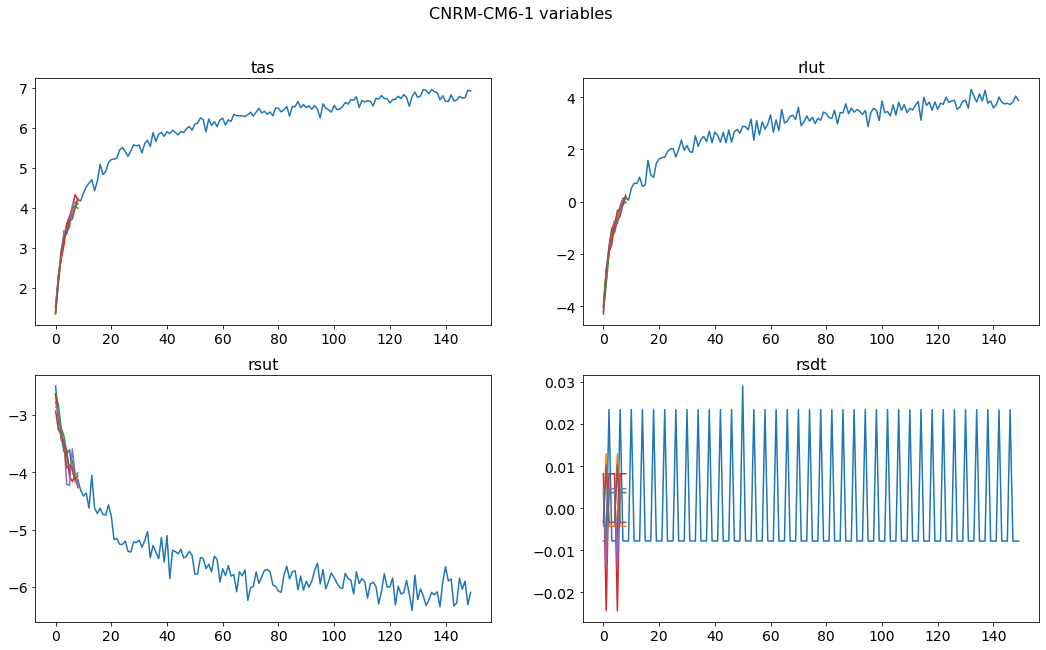

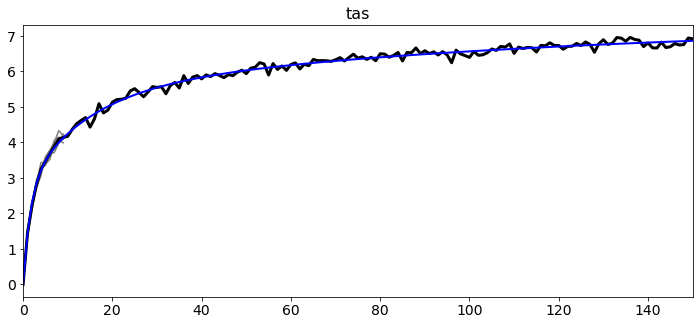

In [293]:

#model = 'CanESM5';
#model = 'IPSL-CM6A-LR'
#model = 'GISS-E2-1-G'
#model = 'FIO-ESM-2-0'
#model = 'CAMS-CSM1-0'
#model = 'FGOALS-f3-L'
#model = 'MRI-ESM2-0'
#model = 'ACCESS-CM2'
model = 'CNRM-CM6-1'

# check which members are available:
members = find_members(model, exp)
print(members)

if model == 'GISS-E2-1-G':
    # exclude member which seems to start after year 150
    members.remove('r1i1p1f3')
    
plot_allvar(model, exp, members)

var = 'tas'; stopyear = 150
years = np.arange(1, stopyear + 1); years0 = np.arange(0, stopyear + 1)

fig, ax = plt.subplots(figsize = [12,5])
ax.set_xlim(0,stopyear)
ax.set_title(var, fontsize = 16)
ax.tick_params(axis='both',labelsize=14)
#ax.set_ylim(0,9)
   
for (mb, member) in enumerate(members):
    data = load_anom(model, exp, member, length_restriction = stopyear)
    deltaT0 = np.concatenate([[0],data[var]])
    ax.plot(years0[:len(deltaT0)], deltaT0, color = 'gray') 
    
meanT0 = mean_4xCO2tas(model, members, length_restriction = stopyear)
ax.plot(years0, meanT0, color='black', linewidth = 3);


dim = 3
taulist = random_tau(dim)
# compute predictors (1 - np.exp((-t/tau[i])) of the linear model
tas_pred = tas_predictors(t = years0, fixed_par = taulist);
# find parameters a_n in: deltaT = \sum_i a_n[i]*(1 - np.exp((-t/tau[i]))
a_n, rnorm1 = optimize.nnls(tas_pred,meanT0) # non-negative least squares, to ensure positive parameters
Ti = np.array([tas_pred[:,i]*a_n[i] for i in range(0,dim)]) # compute components
Tsum = tas_pred@a_n # sum of all components

ax.plot(Tsum, color = 'blue', linewidth = 2);
